In [2]:
import pickle
import pandas as pd
import numpy as np
from collections import defaultdict
from random import shuffle

# web scraping libraries
from pynyt import NYTArticleAPIObject
import requests
from bs4 import BeautifulSoup

# NLP libraries
from textblob import TextBlob
import nltk

#plotting libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
df_1987.to_pickle('df_1987.pickle')
df_2017.to_pickle('df_2017.pickle')

In [3]:
df_1987 = pd.read_pickle('df_1987.pickle')
df_2017 = pd.read_pickle('df_2017.pickle')

Whenever I visit home, I find a few hours to leaf through my parents' collection of old ('80s and '90s) National Geographic magazines. Although many of the magazine's advertisements are good for a quick laugh, I'm most fascinated by the longform articles—ambitious, sweeping stories spun across thirty pages or more, the product of many months of work for a writer-photographer team. The best of these articles succeed in distilling the essence of a place or culture into an hour's worth of text and images.

Reading these magazines has led to my developing an interest in the evolution of journalism. Over the years, these lengthy expositions seem to have fallen out of favor, replaced by shorter, more specific articles; in my mind, articles of over thirty pages are definitely a thing of the past. As a newcomer to the field of data science, I thought it would be interesting to verify my intuition using real data. I set out to obtain articles from the past and present, with the goal of making comparisons and determining if enough difference existed to build a predictive model - could a relatively simple model predict whether an article was written recently or not-so-recently?

Unfortunately, accessing National Geographic backlogs online requires a paid subscription. I quickly found an alternative in the New York Times, which allows free access (with daily limits) to its archives via the [Times Developer Network](https://developer.nytimes.com/). A variety of web APIs are provided, a few of which are very useful for combing lots of article data - I chose the Article Search API, which allows the user to narrow down a query using all of the extensive metadata fields. (An Article Search API key can be obtained at the above link.) A couple of Python wrappers do exist for the Article Search API, but none of them are actively maintained and I figured writing my own would be a good exercise, and a good opportunity to learn about the [requests](http://docs.python-requests.org/en/master/) library, among other things. My wrapper class can be found in pynyt.py—it worked very well for the purposes of this project, although there does seem to be a non-deterministic bug when making too many queries in a single notebook block.

In [4]:
miner = NYTArticleAPIObject('my api key is a secret! get your own! mine mine mine')

miner.get_usage()

999


`get_usage()` returns the number of API calls permitted for the day, the limit being 1000. (Calling the function also consumes a precious API call—a truly unfortunate necessity.) There are more limitations: a query can only return up to 1000 article results; if a query is too broad, results past the thousandth article will be cut off. Additionally, the results are returned 10 at a time, across up to 100 pages, and grabbing each page requires an API call.

For this project, these API limitations are inconsequential. I decided to grab 2,000 articles each from 2017 and 1987 - hopefully plenty for analysis and modeling, with more than half of my all-important API calls to spare. The Times publishes a wide variety of written material—in addition to traditional articles, material types include editorials, op-eds, columns, interviews, obituaries, and so forth. I wanted to limit this analysis to what I most readily associate with the New York Times: news stories written by Times reporters. The below queries pull 2,000 Times-sourced news articles each from the relevant years. Within a given year's results, 1,000 articles are from the foreign news desk and 1,000 are from the national news desk. This limitation is imposed with the additional goal of obtaining articles from 1987 and 2017 written about broadly similar topics (in order to focus the analysis and modeling on the style and conventions of the journalism itself, rather than the subject matter).

The code is split into four blocks to avoid the aforementioned bug, the exact cause of which I have yet to determine. The results are returned as a list of dictionaries, each entry being a page of query results (i.e. data for up to 10 articles). The responses are supposed to be ordered by relevancy, although in actuality I think all matching results are returned in order of recency of publication. Even in that case, 2,000 articles for a given year should make for a week or two's worth of news from around the world, which ought to be a diverse enough dataset for this purpose.

(If you're running this yourself, you might want to set verbose=True in the function call to see the progress—each call will pull 100 pages of article metadata.)

In [ ]:
results_1987 = miner.query(fq = {'source': 'New York Times',
                                  'news_desk': 'Foreign',
                                  'type_of_material': 'News'},
                            begin_date = 19870101,
                            end_date = 19871231,
                            halt_overflow = False)

In [ ]:
results_1987 += miner.query(fq = {'source': 'New York Times',
                                 'news_desk': 'National',
                                 'type_of_material': 'News'},
                            begin_date = 19870101,
                            end_date = 19871231,
                            halt_overflow = False)

In [ ]:
results_2017 = miner.query(fq = {'source': 'New York Times',
                                 'news_desk': 'Foreign',
                                 'type_of_material': 'News'},
                           begin_date = 20170101,
                           halt_overflow = False)

In [ ]:
results_2017 += miner.query(fq = {'source': 'New York Times',
                                  'news_desk': 'National',
                                  'type_of_material': 'News'},
                            begin_date = 20170101,
                            halt_overflow = False)

As illustrated [here](https://developer.nytimes.com/article_search_v2.json#/README) (scroll down to example responses), all sorts of metadata is returned, much of which I didn't think I would need to use. I was most interested in approaching this as a text classification study, so for a given article, all I really needed was the body of text and perhaps the headline and date. As it turned out, the responses do not contain the actual text of each article, so I also ended up having to grab each article's URL for scraping. These fields were loaded into another list of dictionaries for easy conversion to a Pandas dataframe shortly down the line.

(In the below function, I accidentally pull the source of the article as well, which is unneccessary given that the query results were limited to those from the New York Times.)

In [46]:
def results_to_list(results): # not a great name - results is a list of dicts too
    results_list = []
    for i in range(len(results)):
        for article in results[i]['response']['docs']:
            source = ''
            if 'source' in article:
                source = article['source']
            results_list.append({'date': article['pub_date'],
                            'headline': article['headline']['main'],
                            'web_url': article['web_url'],
                            'source': source})
    return results_list

list_1987 = results_to_list(results_1987)
list_2017 = results_to_list(results_2017)

In [79]:
with open('list_1987.pickle', 'rb') as f:
    list_1987 = pickle.load(f)
with open('list_2017.pickle', 'rb') as f:
    list_2017 = pickle.load(f)

In [80]:
df_1987 = pd.DataFrame(list_1987)
df_2017 = pd.DataFrame(list_2017)

df_1987.head()

,date,headline,source,web_url
0,1987-12-31T00:00:00Z,The Hills Are Not Alive With the Swoosh of Skis,The New York Times,https://www.nytimes.com/1987/12/31/world/the-h...
1,1987-12-31T00:00:00Z,Kabul Says a Convoy Breaks Siege of a City,The New York Times,https://www.nytimes.com/1987/12/31/world/kabul...
2,1987-12-31T00:00:00Z,Al Ghourayib Journal; And if the Nile Dries Up...,The New York Times,https://www.nytimes.com/1987/12/31/world/al-gh...
3,1987-12-31T00:00:00Z,Salvador Court Frees 2 Killers of Americans,The New York Times,https://www.nytimes.com/1987/12/31/world/salva...
4,1987-12-31T00:00:00Z,Rights Group Invited to Moscow For Week of Tal...,The New York Times,https://www.nytimes.com/1987/12/31/world/right...


With the data from the API queries loaded into dataframes, the next step is to scrape the text from each article and add it to the dataframes. This can be accomplished by using BeautifulSoup and inspecting New York Times article source code to find the right tags to search for. Looking at a few articles from 1987 and 2017, it looks like the text body is contained in paragraph tags with `itemprop='articleBody'` for 1987 articles and `class_='story-body-text story-content'` for 2017 articles. I'm not sure if these were uniform conventions for the given years, and so the scraping code makes sure to check for empty or very short strings (the result of a failure to find the right tags).

In [ ]:
from bs4 import BeautifulSoup

df_1987['text'] = ""
df_2017['text'] = ""

def get_text(df):
    session = requests.Session()
    
    for i in range(len(df)):
        if i % 100 == 0:
            print('Processing url', i)
        url = df.iloc[i]['web_url']
        req = session.get(url)
        soup = BeautifulSoup(req.text, "html5lib")
        # paragraphs = soup.find_all('p', itemprop = 'articleBody') # 1987 articles
        paragraphs = soup.find_all('p', class_='story-body-text story-content') # 2017 articles

        txt = ''
        for p in paragraphs: # newlines for nice printing + paragraph analysis
            # txt += p.getText() # 1987 - newlines already written in
            txt += p.getText() + "\n" # 2017
        df.set_value(i, 'text', txt)
    
    return df

# df_1987 = get_text(df_1987)
df_2017 = get_text(df_2017)

In [89]:
def get_problem_indices(df):
    problem_indices = []
    for idx, article in df.iterrows():
        length = len(article['text'])
        if length < 100:
            print('Length {} at URL {}: {}'.format(length, idx, article['web_url']))
            problem_indices.append(idx)
    return problem_indices

print('1987')
problem_indices_1987 = get_problem_indices(df_1987)
print('2017')
problem_indices_2017 = get_problem_indices(df_2017)

1987
2017
Length 0 at URL 896: https://www.nytimes.com/2017/06/16/world/canada/the-times-in-canada.html
Length 0 at URL 1264: https://www.nytimes.com/2017/07/21/us/politics/trump-communications-scaramucci-sanders.html
Length 0 at URL 1340: https://www.nytimes.com/2017/07/17/us/politics/trump-laws-bills.html
Length 0 at URL 1376: https://www.nytimes.com/2017/07/14/us/how-poems-inspire-pictures.html
Length 0 at URL 1398: https://www.nytimes.com/2017/07/12/us/politics/trump-russia-election-meeting.html
Length 0 at URL 1442: https://www.nytimes.com/2017/07/10/us/western-wildfires.html
Length 0 at URL 1472: https://www.nytimes.com/2017/07/07/us/politics/senate-hobbies.html
Length 0 at URL 1536: https://www.nytimes.com/2017/06/30/us/handmaids-protests-abortion.html
Length 0 at URL 1612: https://www.nytimes.com/2017/06/25/us/extreme-heat-scorches-southern-arizona.html


No problematic articles are encountered in the 1987 dataframe, but get_text() fails to obtain any text for several 2017 articles, as seen in the output above.

Looking at the problematic articles, it's apparent that the issue arises from the articles possessing an unusual layout, perhaps for web-only presentation. The text is contained in paragraph tags with a very long class name, which will not be reproduced here! The articles are re-scraped using said class name and the lengths of each new text is printed to check whether the class name applies to all of the problematic articles. A reasonable number of characters are thus found for each of the articles, so it looks like no further fixes are required.

In [91]:
session = requests.Session()
p_class = "Paragraph-paragraph--2eXNE OakElement-paragraph--2e5h2 OakElement-left--2eGEj OakElement-toneFeature--uJSyt OakParagraph-headerHasNoLedeMedia--1Uoi7"
for idx in problem_indices_2017:
    url = df_2017.iloc[idx]['web_url']
    req = session.get(url)
    soup = BeautifulSoup(req.text, 'html5lib')
    paragraphs = soup.find_all('p', class_ = p_class)

    txt = ''
    for p in paragraphs:
        txt += p.getText() + "\n" # 2017
        
    print(len(txt))
    
    df_2017.set_value(idx, 'text', txt)

2919
4569
14312
10545
10371
3891
9564
5032
4024


Now that all the articles have been scraped, one of the initial questions—whether article length has changed over time—can be answered. This code adds columns to the dataframe for article length in words, as well as headline length, for good measure.

In [7]:
def get_length(text):
    return len(text.split())

df_1987['length'] = df_1987['text'].map(get_length)
df_2017['length'] = df_2017['text'].map(get_length)
df_1987['headline_length'] = df_1987['headline'].map(get_length)
df_2017['headline_length'] = df_2017['headline'].map(get_length)
display(df_1987.describe())
display(df_2017.describe())

,length,headline_length
count,2000.00000,2000.000000
mean,603.60700,7.381000
std,326.77331,2.433269
min,27.00000,1.000000
25%,324.00000,6.000000
50%,631.00000,7.000000
75%,857.25000,9.000000
max,1361.00000,25.000000


,length,headline_length
count,2000.000000,2000.000000
mean,965.439500,9.963500
std,445.391875,1.880674
min,41.000000,3.000000
25%,628.000000,9.000000
50%,937.500000,10.000000
75%,1240.000000,11.000000
max,4569.000000,19.000000


The results are quite suprising—article and headline length are both significantly longer today than in 1987, on average. Plotting the distributions might uncover some further insights. We can start with article length:

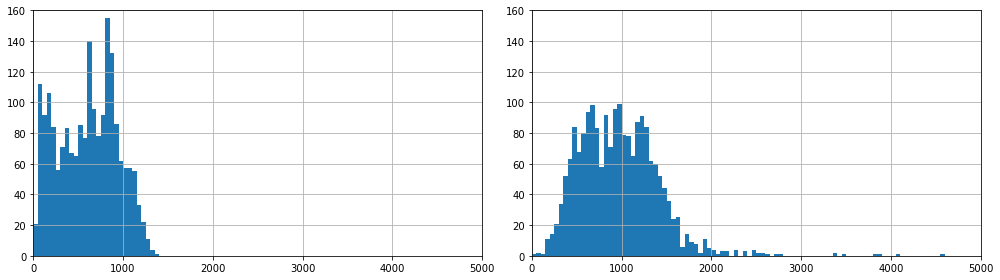

In [16]:
def plot_subplots(series, axis, my_color):
    axis.hist(series, bins=np.linspace(0, 5000, 101)) # bucket size of 50
    axis.set_ylim(0, 160)
    axis.set_xlim(0, 5000)
    axis.grid()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14, 4)

plot_subplots(df_1987['length'], axs[0], 'b')
plot_subplots(df_2017['length'], axs[1], 'r')
fig.tight_layout()

The distributions are quite different. The 1987 article length histogram seems roughly bimodal, with many of the articles being either very short (under 250 words) or of moderate length (500-1000 words). Relatively few articles of length greater than 1000 words are published. On the other hand, the distribution for 2017 appears to be closer to normal, albeit more strongly right-skewed. Articles below 250 words in length are nearly completely absent, and half or so of the articles appear to be at least 1000 words long.

The abundance of very short articles in the 1987 dataset is quite interesting. [Here's](https://www.nytimes.com/1987/12/28/world/new-zealand-fire-kills-3.html) the shortest article of them all—just one sentence long!

In [8]:
len_min_idx = df_1987['length'].argmin()
print(df_1987.iloc[len_min_idx]['length'])
print(df_1987.iloc[len_min_idx]['headline'])
print(df_1987.iloc[len_min_idx]['text'])

27
New Zealand Fire Kills 3

                    AUCKLAND, New Zealand, Dec. 27— 
                    Fire destroyed a hotel today and killed three children in the town of Taneatua, 150 miles south of Auckland, the police said.        


Why might the distributions be so different? One factor could be that some of the long articles from 2017 are web-only publications, free of restrictions on length imposed by the print newspaper format. Finding an easy explanation for the decline of very short articles is a bit more difficult. It seems reasonable to attribute this change to an evolution in the Times's underlying protocols over time—articles of just a few sentences have simply fallen out of favor.

Similarly, we can plot the distributions for headline length. In this case, boxplots as well as histograms make for interesting representations of the data:

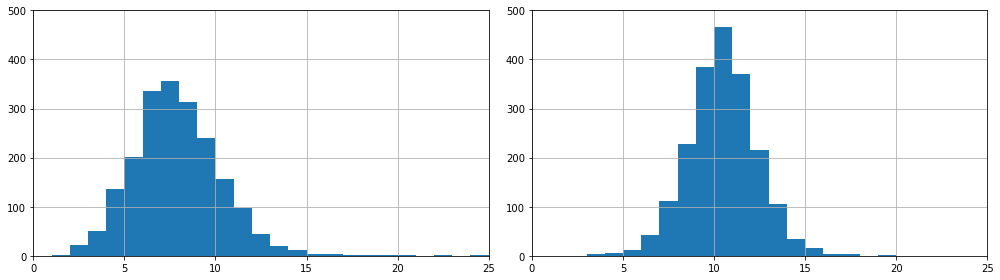

In [310]:
def plot_subplots(series, axis, my_color):
    axis.hist(series, bins=np.linspace(0, 25, 26)) # bucket size of 1
    axis.set_ylim(0, 500)
    axis.set_xlim(0, 25)
    axis.grid()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14, 4)

plot_subplots(df_1987['headline_length'], axs[0], 'b')
plot_subplots(df_2017['headline_length'], axs[1], 'r')
fig.tight_layout()

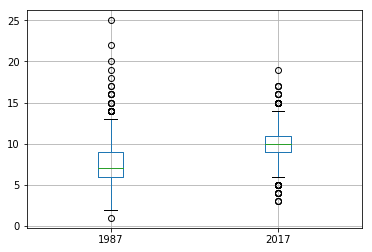

In [9]:
combined_headlines = pd.concat([df_1987['headline_length'], df_2017['headline_length']],
                                axis=1,
                                keys=['1987', '2017'])

combined_headlines.boxplot()

Interestingly, the histogram distribution is significantly tighter for headlines written in the current year, further signified by the small interquartile ranges and abundance of outliers on both sides of the 2017 boxplot. The reduction in variability might indicate that headline writing is more standardized overall today than it was in 1987.

Another feature of potential interest is the average sentence length in a given article. Splitting at every period might not be the most intelligent way to go about this task, given the likely prevalence of abbreviations in these articles. The [TextBlob library](https://textblob.readthedocs.io/en/dev/), which provides a simple API for common NLP tasks, has functionality for splitting a text into sentences, so it's worth trying it out here. (I eventually move on to using nltk for modeling purposes, but since this is a first foray into NLP, TextBlob serves as a good starting point.)

In [10]:
def get_mean_sentence_length(text):
    sentences = TextBlob(text).sentences
    lengths = []
    for s in sentences:
        lengths.append(len(s.words))
    return sum(lengths) / len(lengths)

df_1987['mean_sentence_length'] = df_1987['text'].map(get_mean_sentence_length)
df_2017['mean_sentence_length'] = df_2017['text'].map(get_mean_sentence_length)

combined_sentences = pd.concat([df_1987['mean_sentence_length'], df_2017['mean_sentence_length']],
                                axis=1,
                                keys=['1987', '2017'])

display(combined_sentences.describe())

,1987,2017
count,2000.000000,2000.000000
mean,23.949195,27.821021
std,4.259242,5.003114
min,9.090909,9.175000
25%,21.063497,24.435619
50%,23.630604,27.482051
75%,26.464493,30.924015
max,57.500000,53.571429


With the advent of longer articles, sentences have actually gotten longer, too. Plotting the distributions with a histogram might be interesting.

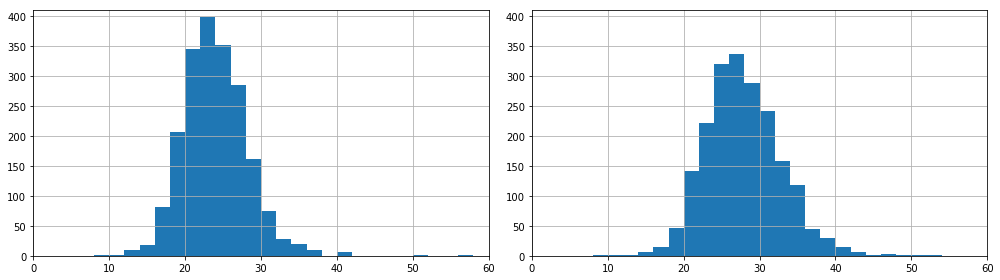

In [22]:
def plot_subplots(series, axis, my_color):
    axis.hist(series, bins=np.linspace(0, 60, 31)) # bucket size of 2
    axis.set_ylim(0, 410)
    axis.set_xlim(0, 60)
    axis.grid()

fig, axs = plt.subplots(1,2)
fig.set_size_inches(14, 4)

plot_subplots(df_1987['mean_sentence_length'], axs[0], 'b')
plot_subplots(df_2017['mean_sentence_length'], axs[1], 'r')
fig.tight_layout()

It looks like the 2017 distribution is a little bit broader, perhaps indicating further stylistic freedoms in modern-day journalistic writing compared to the rigidities of old. This makes for an interesting contrast when compared to the decline in variation in headline lengths.

Sentiment analysis is another avenue of exploration for comparing these sets of articles. The polarity (-1.0 to 1.0, negative to positive) and subjectivity (0.0 to 1.0, objective to subjective) of a text can be obtained easily using TextBlob's sentiment analyzer. The polarity and subjectivity can be added to the dataframes as with the previous measures.

In [11]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

df_1987['polarity'] = df_1987['text'].map(get_polarity)
df_2017['polarity'] = df_2017['text'].map(get_polarity)

df_1987['subjectivity'] = df_1987['text'].map(get_subjectivity)
df_2017['subjectivity'] = df_2017['text'].map(get_subjectivity)

In [12]:
df_1987[['polarity', 'subjectivity']].describe()

,polarity,subjectivity
count,2000.000000,2000.000000
mean,0.054308,0.373114
std,0.073908,0.095442
min,-0.500000,0.000000
25%,0.012960,0.325357
50%,0.055558,0.379736
75%,0.096405,0.428867
max,0.600000,1.000000


In [13]:
df_2017[['polarity', 'subjectivity']].describe()

,polarity,subjectivity
count,2000.000000,2000.000000
mean,0.056852,0.387228
std,0.055530,0.063004
min,-0.198056,0.000000
25%,0.023458,0.349520
50%,0.058852,0.391664
75%,0.093797,0.427676
max,0.290000,0.594872


These sentiment measures are actually very similar between the two groups. Subjectivity in particular is surprisingly high (~0.4); for a news source to be only moderately objective seems unintuitive. There also appear to be some wacky outliers, as the maximum subjectivity value of 1.0 in df_1987 indicates. We can try taking a look at that particular article.

In [14]:
max_subj = df_1987['subjectivity'].argmax()
te = (df_1987.iloc[max_subj]['text'])
print(te)
print(df_1987.iloc[max_subj]['subjectivity'])


                    BURLINGTON, Vt., Dec. 19— 
                    Look USA, a distributor of French-made alpine ski bindings, is recalling 13 models to fix a defect that could cause the binding to release unexpectedly, the company said Friday.        
                    Consumers were being asked to return the 30,000 bindings to authorized dealers for adjustment, a company spokesman said. The company had received complaints about the bindings but no injuries have been reported, he added.        
                    The models being recalled are ZRC, ZR, ZP, ZL, ZRJ, X-9, X-7, X-5, XH, XF, XFL, XG, XGR.        
1.0


The relevant article is quite short, which may contribute to the extreme value; nonetheless, nothing about the text itself seems amiss. If anything, the article appears to be quite objective. To explore further, the text is broken up into individual words and the TextBlob sentiment analyzer is used to compute the subjectivity of each individual word:

In [116]:
subjs = defaultdict(set)

for word in te.split():
    sub = TextBlob(word).sentiment.subjectivity
    subjs[sub].add(word)

for sub in subjs:
    print('{}: {}\n'.format(sub, subjs[sub]))

0.0: {'ZL,', 'been', '30,000', 'about', 'Consumers', 'said', 'he', 'XGR.', 'bindings', 'added.', 'return', 'X-5,', 'Look', 'dealers', 'alpine', 'recalled', 'of', 'the', 'had', 'could', 'XFL,', 'defect', 'recalling', 'company', 'ZR,', 'for', 'received', 'release', 'ZP,', 'ZRJ,', 'X-7,', 'XG,', 'distributor', 'ski', 'said.', 'that', 'fix', 'authorized', 'are', 'a', 'no', 'Friday.', 'reported,', 'X-9,', 'to', 'spokesman', 'were', 'is', 'Dec.', '19—', 'cause', 'adjustment,', 'The', 'injuries', 'USA,', 'ZRC,', 'complaints', 'have', 'but', 'models', '13', 'asked', 'XF,', 'being', 'binding', 'French-made', 'bindings,', 'Vt.,', 'XH,', 'BURLINGTON,'}

1.0: {'unexpectedly,'}



It looks like the article falls on the other extreme—extremely objective! All but one of the words has a subjectivity score of 0.0, yet the single word with a score of 1.0 (fittingly, 'unexpectedly') completely throws off the overall score. Playing around with some test strings, it looks like the sentiment algorithm entirely ignores words with score 0.0 (a score assigned to many, many words). One has to believe that with cases like the above, this can't be intended behavior. I believe TextBlob uses a wrapper of the sentiment analyzer from the `pattern` library, where the problem may lay. As it stands, I am currently unfamiliar with said library's codebase—perhaps a project for next week....

The last part of this investigation involves training a model for identifying the year in which a given article was published. However, given that each data point is about 750 words long on average and I'm running this notebook on a laptop, nltk's algorithms were unsurprisingly unable to perform this classification task in a reasonable amount of time. I've decided to focus my modeling solely on the headlines for now.

The most effective single-model option would probably be to implement a bag-of-words approach. It's likely that some words are much more common in 2017 headlines than 1987 headlines (eg. Trump, Russia, etc.), and vice versa (eg. Reagan, Soviet, etc.). I'm more interested in seeing if headline structure and style conventions have changed in the course of the past thirty years. One way to investigate this is to use part-of-speech tagging, which assigns each word in the text a tag which can be used as a feature for a machine learning algorithm. To link parts of speech to sentence structure, we can link adjacent tags together to form bigrams. In the following code, every bigram across the set of all headlines is cataloged and the 300 most common bigrams are pulled for use as binary features for each headline.

In [28]:
all_headlines = []
for h in df_1987['headline']:
    all_headlines.append((h, '1987'))
for h in df_2017['headline']:
    all_headlines.append((h, '2017'))

tokenizer = nltk.RegexpTokenizer(r'\w+') # removes punctuation

pos_bigrams = []
for h in all_headlines:
    tokenized = tokenizer.tokenize(h[0].lower())
    pos_tagged = nltk.pos_tag(tokenized)
    for i in range(len(pos_tagged) - 1):
        pos_bigrams.append((pos_tagged[i][1], pos_tagged[i+1][1]))

In [29]:
all_bigrams = nltk.FreqDist(pos_bigrams)
common_bigrams_list = list(all_bigrams.most_common())[:300]
bigram_features = [b[0] for b in common_bigrams_list]

print(len(all_bigrams))
print(len(bigram_features))

474
300


Next, a feature vector must be generated for each headline, with each feature indicating the presence of a given part-of-speech bigram in the headline. The function `get_ngram_features()` constructs this vector for a given headline. A list comprehension is used to generate a list of tuples with the feature vector and year label for each headline.

In [30]:
def get_ngram_features(headline):
    features = {}
    tokenized = tokenizer.tokenize(headline.lower())
    pos_tagged = nltk.pos_tag(tokenized)
    
    headline_bigrams = []
    for i in range(len(pos_tagged) - 1):
        headline_bigrams.append((pos_tagged[i][1], pos_tagged[i+1][1]))
        
    for b in bigram_features:
        features['contains {}'.format(b)] = b in headline_bigrams
        
    return features

featuresets = [(get_ngram_features(h), y) for (h,y) in all_headlines]

With the feature vectors and labels prepared, we can split the data into training and test sets and attempt classification. I chose to use a naive Bayes classifier, since it trains quickly and the part-of-speech bigrams convey word order information (alleviating a usual weakness of the algorithm—no understanding of word sequence). Since we have quite a bit of data on our hands (4000 headlines), much of it can be put aside for training; a 75:25 train:test split is used here.

In [50]:
shuffle(featuresets)
train, test = featuresets[:3000], featuresets[3000:]
headline_clf = nltk.NaiveBayesClassifier.train(train)
nltk.classify.accuracy(headline_clf, test)

0.706

Given that this is a binary classification problem, an accuracy of 0.706 isn't fantastic, but getting a moderate accuracy using only part-of-speech bigrams is pretty cool! We can use the show_most_informative_features() function to learn a bit more about the biggest differences between the two classes. (Note: shuffling and re-running the training can result in variations in accuracy of several percent, as well as different orderings of the most important features.)

In [51]:
headline_clf.show_most_informative_features(15)

Most Informative Features
   contains ('RB', 'CC') = True             2017 : 1987   =     10.1 : 1.0
  contains ('RB', 'VBP') = True             2017 : 1987   =      9.4 : 1.0
  contains ('WRB', 'JJ') = True             2017 : 1987   =      8.1 : 1.0
 contains ('VB', 'PRP$') = True             2017 : 1987   =      6.8 : 1.0
  contains ('WRB', 'DT') = True             2017 : 1987   =      6.2 : 1.0
 contains ('VBG', 'PRP') = True             2017 : 1987   =      6.2 : 1.0
  contains ('NNS', 'WP') = True             2017 : 1987   =      6.2 : 1.0
   contains ('JJ', 'VB') = True             2017 : 1987   =      6.2 : 1.0
  contains ('WP', 'VBD') = True             2017 : 1987   =      6.2 : 1.0
 contains ('VBZ', 'VBP') = True             2017 : 1987   =      6.2 : 1.0
  contains ('CC', 'VBD') = True             2017 : 1987   =      5.7 : 1.0
  contains ('PRP', 'IN') = True             2017 : 1987   =      4.9 : 1.0
 contains ('VBG', 'VBN') = True             2017 : 1987   =      4.2 : 1.0

Interestingly, nearly all of the most important features were found to be more prevalent in 2017 headlines than 1987 headlines; perhaps 1987 headlines tend to be more structurally uniform with regards to part-of-speech than 2017 headlines, hence the abundance of strong indicators of headlines written in 2017. On the other hand, we know that 2017 headlines are longer on average than 1987 headlines, so the skew may just be a reflection of the greater number of bigrams in 2017 headlines to begin with. We might be able to learn more if we can see the relevant headlines themselves.

The part-of-speech bigrams themselves don't mean much when presented like this, but consulting [a list of the tags](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) helps make them a bit more sensible. More importantly, we should be able to use a bit of code to see them in context. This function prints all the headlines containing a given bigram, and capitalizes the words of first occurrence of that bigram. Let's try it out with the strongest feature, ('RB', 'CC').

In [54]:
def print_feat_headlines(feat):
    for h in all_headlines:
        pos_bigrams = []
        tokenized = tokenizer.tokenize(h[0].lower())
        pos_tagged = nltk.pos_tag(tokenized)
        for i in range(len(pos_tagged) - 1):
            pos_bigrams.append((pos_tagged[i][1], pos_tagged[i+1][1]))
        if feat in pos_bigrams:
            idx = pos_bigrams.index(feat)
            sp = tokenized
            sp[idx] = sp[idx].upper()
            sp[idx+1] = sp[idx+1].upper()
            print('{}: {}'.format(h[1], ' '.join(sp)))

print_feat_headlines(('RB', 'CC'))

1987: o neill UP AND walking
2017: cyprus reunification talks CLOSE BUT not close enough fail
2017: a prague leader tries to bury a bodies exhibition ONCE AND for all
2017: immigration moves FRONT AND center in italy s local elections
2017: turks click AWAY BUT wikipedia is gone
2017: obama s global visits inspire wistful comparisons of THEN AND now
2017: RIGHT AND left react to the tensions with north korea
2017: RIGHT AND left react to the justice dept s moves on affirmative action
2017: RIGHT AND left on anthony scaramucci s dismissal and john f kelly s new role
2017: RIGHT AND left on the russia sanctions and putin s response
2017: RIGHT AND left react to kushner sessions and more
2017: RIGHT AND left react to trump s interview health care and more
2017: RIGHT AND left react to the donald trump jr email scandal
2017: RIGHT AND left on the future of the senate health care bill
2017: RIGHT AND left react to trump s norm defying tweets
2017: trump warms to old idea kill health law NOW

Whoops! A bunch of the 2017 headlines appear to just be entires in a series titled 'Right and Left', nonexistent in 1987. This isn't really the kind of insight I was hoping to glean from the model, so it would be good to remove the ('RB', 'CC') tag from the list of bigrams for the feature vectors and retrain the model. (As it turns out, the bigram corresponding to 'and left', ('CC', 'VBD'), is also skewing the model, so it's removed below as well.)

In [58]:
avoid = [('RB', 'CC'), ('CC', 'VBD')]
for a in avoid:
    if a in bigram_features:
        bigram_features.remove(a)
        
print(len(bigram_features))
        
featuresets = [(get_ngram_features(h), y) for (h,y) in all_headlines]

298


In [63]:
shuffle(featuresets)
train, test = featuresets[:3000], featuresets[3000:]
headline_clf = nltk.NaiveBayesClassifier.train(train)
nltk.classify.accuracy(headline_clf, test)

0.681

As might be expected, the accuracy takes a bit of a hit, but now there might be more interesting differentiators.

In [64]:
headline_clf.show_most_informative_features(15)

Most Informative Features
  contains ('WP', 'VBZ') = True             2017 : 1987   =      9.1 : 1.0
  contains ('WRB', 'JJ') = True             2017 : 1987   =      7.8 : 1.0
 contains ('VBG', 'PRP') = True             2017 : 1987   =      7.8 : 1.0
  contains ('NNS', 'WP') = True             2017 : 1987   =      7.1 : 1.0
  contains ('CC', 'PRP') = True             2017 : 1987   =      5.7 : 1.0
  contains ('NN', 'PRP') = True             2017 : 1987   =      5.3 : 1.0
  contains ('RB', 'PRP') = True             2017 : 1987   =      5.1 : 1.0
 contains ('VBZ', 'JJR') = True             2017 : 1987   =      5.1 : 1.0
  contains ('VBN', 'RP') = True             2017 : 1987   =      5.1 : 1.0
  contains ('PRP', 'IN') = True             2017 : 1987   =      5.1 : 1.0
   contains ('RP', 'DT') = True             2017 : 1987   =      5.1 : 1.0
 contains ('PRP', 'VBP') = True             2017 : 1987   =      5.1 : 1.0
  contains ('WP', 'VBD') = True             2017 : 1987   =      4.9 : 1.0

We can use the function written earlier to investigate some more of these bigrams in context. Let's start with the model's most useful bigram, ('WP', 'VBZ').

In [67]:
print_feat_headlines(('WP', 'VBZ'))

1987: paris journal a french thinker WHO DECLINES a guru mantle
1987: the questions begin WHO IS anthony kennedy
1987: the emerging candidate WHO IS senator simon
1987: bishop WHO SPEAKS for downtrodden
2017: israel court rejects appeal for elor azaria soldier WHO SHOT wounded assailant
2017: minneapolis police shooting of australian woman WHAT IS known so far
2017: WHO PAYS for pell s day in court also cracks form in the gig economy
2017: WHO WANTS to be king no one prince harry says
2017: waiting in the wings in kansas WHO IS lt gov jeff colyer
2017: WHO WANTS to run that mom and pop market almost no one
2017: a patriotic fourth WHAT DOES that mean now
2017: the criminals have been captured now WHO GETS the reward
2017: WHO IS karen handel winner of the georgia special election
2017: c b o head WHO PRIZES nonpartisanship finds work under g o p attack
2017: WHO IS ralph northam virginia s democratic nominee for governor
2017: WHO IS ed gillespie virginia s g o p nominee for governor
2

This is pretty interesting—a who-pronoun followed by a third-person singular present verb is a much more common construction in 2017 headlines. Perhaps this is linked to the increased length of headlines on average, giving more space for the kinds of compound sentences that would be likely to use this kind of structure. Also, there appears to be a new prevalence in 'Who ____?'-type headlines.

Let's try looking at one more relevant bigram—('WRB', 'JJ').

In [68]:
print_feat_headlines(('WRB', 'JJ'))

1987: washington talk census bureau HOW PROBLEMATIC the 1990 enumeration let us count the ways
2017: HOW INDIA and china have come to the brink over a remote mountain pass
2017: no jab no play HOW AUSTRALIA is handling the vaccination debate
2017: WHEN YOUNG chinese ask what s your sign they don t mean dragon or rat
2017: WHY UPROOTING corruption has plunged brazil into chaos
2017: HOW MANY died in london fire anger rises as police won t say for sure
2017: HOW CARDINAL pell rose to power trailed by a cloud of scandal
2017: for macron s party in france success is broad but HOW DEEP
2017: transcripts show HOW CONTENTIOUS trump s calls were with mexican and australian leaders
2017: HOW SCHUMER held democrats together through a health care maelstrom
2017: HOW U s military policy on transgender personnel changed under obama
2017: HOW POEMS inspire pictures
2017: HOW LOW can taxes go outside washington republicans find limits
2017: HOW MICHAEL flynn s disdain for limits led to a legal quagmi

Again, this seems to indicate a new 'kind' of headline: 'How ____'. This sort of headline conveys a more explanatory type of article, rather than a piece informing the reader of a specific newsworthy event. It seems that new conventions and standards in headline writing have come into place, perhaps as a result of more variety in the types of articles being published, as seen in this example. Further resolving these findings with the previous knowledge that headline lengths are actually less widely distributed today than in 1987 would be an interesting area of exploration.

Lastly, given the apparent skewing in the important features towards bigrams present in 2017 headlines, it would be worthwhile to look at the precision and recall of the classifier to assess whether classification is skewed at all between the two categories. nltk includes these metrics, so finding the precision and recall can be accomplished as follows:

In [71]:
from nltk.metrics.scores import precision, recall
from collections import defaultdict

refsets = defaultdict(set)
testsets = defaultdict(set)

for i, (feats, year) in enumerate(test):
    refsets[year].add(i)
    observed = headline_clf.classify(feats)
    testsets[observed].add(i)

In [72]:
print('1987 precision:', precision(refsets['1987'], testsets['1987']))
print('1987 recall:', recall(refsets['1987'], testsets['1987']))
print('2017 precision:', precision(refsets['2017'], testsets['2017']))
print('2017 recall:', recall(refsets['2017'], testsets['2017']))

1987 precision: 0.6610486891385767
1987 recall: 0.7189409368635438
2017 precision: 0.703862660944206
2017 recall: 0.6444007858546169


The lower precision for 1987 headlines and lower recall for 2017 headlines indicate that the algorithm more often misclassifies 2017 headlines as 1987 headlines than vice versa. This is a bit surprising given that there seemed to be many strong indicators for 2017 headlines, which would imply that 2017 headlines were more likely to be classified correctly. However, the features that were investigated in detail only occurred in a small fraction of the headlines, so 